In [19]:
import numpy as np
import pandas as pd
import os
from datetime import datetime,timedelta
import math
import matplotlib.pyplot as plt
import seaborn  


#Show the follwoing by Q or Y
#1.plot line chart cumulativ return (ROC) 
#2.plot bar pct  (ROC)
#3.plot correlation
#4. excel desc

#https://www.geeksforgeeks.org/python-pandas-dataframe-cumprod/
#https://www.dataquest.io/blog/how-to-plot-a-bar-graph-matplotlib/



In [20]:
from_str='2022-10-01'
to_str='2023-01-31'
feq ='M'  # support month=M,quater=Q,year=Y
title=f"SMALL-THAI-{feq}"

#data_file=data_path=r"D:\PythonDev\MyQuantFinProject\Data\TiscoThai_y20t22.csv"
data_file=data_path=r"D:\PythonDev\MyQuantFinProject\Data\THAI-SMALL_Y20ToNow.csv"

# Build Asset Timeseries

In [21]:
period_index=pd.date_range(start=from_str,end=to_str, freq=feq)
print(period_index)

# create StartDate as Nan
fundPerfByPeriod_df=pd.DataFrame(index=period_index,columns=['Start_Date'])

# move index to EndDate column
fundPerfByPeriod_df.reset_index(drop=False,inplace=True)

# change columns  index,Start_Date =End_Date,Start_Date
fundPerfByPeriod_df.columns=['End_Date','Start_Date']
# change column order
fundPerfByPeriod_df=fundPerfByPeriod_df[['Start_Date','End_Date']]

print(f"Create the first day of {feq} by iteration")
# print(fundPerfByPeriod_df)

for index,row in fundPerfByPeriod_df.iterrows():
    if index==0:
       fundPerfByPeriod_df.iloc[0,0]=datetime.strptime(from_str,'%Y-%m-%d')
    else:
        # get End_Date(last day of Year, Quater,Month) of previouse row 
        prev_end_date= fundPerfByPeriod_df.iloc[index-1,1] 
        start_date=prev_end_date + timedelta(days = 1) # 
        fundPerfByPeriod_df.iloc[index,0]=start_date 
fundPerfByPeriod_df['Start_Date']=pd.to_datetime(fundPerfByPeriod_df['Start_Date'],format='%Y-%m-%d %H:%M:%S')    

fundPerfByPeriod_df['Period']= fundPerfByPeriod_df.apply( lambda item:f"{item['Start_Date'].strftime('%d')}{item['Start_Date'].strftime('%b')}{item['Start_Date'].strftime('%y')}_{item['End_Date'].strftime('%d')}{item['End_Date'].strftime('%b')}{item['End_Date'].strftime('%y')}"  ,axis=1  )
fundPerfByPeriod_df.info()

print(f"Created {feq} Time Series")
fundPerfByPeriod_df



DatetimeIndex(['2022-10-31', '2022-11-30', '2022-12-31', '2023-01-31'], dtype='datetime64[ns]', freq='M')
Create the first day of M by iteration
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Start_Date  4 non-null      datetime64[ns]
 1   End_Date    4 non-null      datetime64[ns]
 2   Period      4 non-null      object        
dtypes: datetime64[ns](2), object(1)
memory usage: 224.0+ bytes
Created M Time Series


,Start_Date,End_Date,Period
0,2022-10-01,2022-10-31,01Oct22_31Oct22
1,2022-11-01,2022-11-30,01Nov22_30Nov22
2,2022-12-01,2022-12-31,01Dec22_31Dec22
3,2023-01-01,2023-01-31,01Jan23_31Jan23


# Load data and Transform

In [22]:
# source file : Ticker,Date/Time,open,high,low,close,Volume
df = pd.read_csv(data_file,index_col='Date/Time',parse_dates=['Date/Time'],dayfirst=True)

df.index.set_names('date',inplace=True)
df.rename(columns={'Ticker':'symbol','close':'price'},inplace=True)

df=df[['symbol','price']]
df.info()
print(df.tail(10))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3945 entries, 2020-01-02 to 2023-02-02
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   symbol  3945 non-null   object 
 1   price   3945 non-null   float64
dtypes: float64(1), object(1)
memory usage: 92.5+ KB
               symbol  price
date                        
2023-01-20  TISCOMS-A  21.24
2023-01-23  TISCOMS-A  21.26
2023-01-24  TISCOMS-A  21.28
2023-01-25  TISCOMS-A  21.18
2023-01-26  TISCOMS-A  20.92
2023-01-27  TISCOMS-A  21.12
2023-01-30  TISCOMS-A  21.18
2023-01-31  TISCOMS-A  21.21
2023-02-01  TISCOMS-A  21.42
2023-02-02  TISCOMS-A  21.55


# Group Data by Symbol

In [23]:
list_fund_name=df['symbol'].unique().tolist()  
# list_fund_name=['ASP-SME','ASP-THEQ']
print(list_fund_name)

['K-MIDSMALL', 'KKP-TQG', 'KFTHAISM', 'ASP-SME', 'KKP-SM-CAP', 'TISCOMS-A']


In [24]:
dictPriceOfFund={}

for name in list_fund_name:

  fund_df=df.query('symbol==@name')   # https://sparkbyexamples.com/pandas/pandas-dataframe-query-examples/
  fund_df=fund_df.loc[:,['price']]  
  fund_df=fund_df.loc[from_str:to_str,:]   #https://www.geeksforgeeks.org/python-pandas-dataframe-loc/
  fund_df.sort_index(inplace=True)    #https://www.geeksforgeeks.org/python-pandas-dataframe-sort_index/
  if len(fund_df)  >0:
      # price/symbol
      dictPriceOfFund[name]=fund_df
      print(f"======={name} : {len(fund_df)}==========")  
      print(fund_df.tail(3))   

=======K-MIDSMALL : 81==========
            price
date             
2023-01-27  17.90
2023-01-30  18.00
2023-01-31  17.98
=======KKP-TQG : 81==========
            price
date             
2023-01-27   8.91
2023-01-30   8.94
2023-01-31   8.97
=======KFTHAISM : 66==========
            price
date             
2023-01-06  14.34
2023-01-30  14.36
2023-01-31  14.38
=======ASP-SME : 81==========
            price
date             
2023-01-27  18.07
2023-01-30  18.09
2023-01-31  18.18
=======KKP-SM-CAP : 81==========
            price
date             
2023-01-27  17.21
2023-01-30  17.19
2023-01-31  17.15
=======TISCOMS-A : 81==========
            price
date             
2023-01-27  21.12
2023-01-30  21.18
2023-01-31  21.21


# Create directory to store chart and excel

In [25]:
# report_path="D:\PythonDev\MyQuantFinProject\Data\Report"
# report_path=os.path.join (report_path, f"{title}-{feq}-{from_str}_{to_str}")
# if not os.path.exists(report_path):
#  os.makedirs(report_path)

# Plot Line Chart to compare price movement

In [27]:
# calculate percent change (current-prev)/prev*100  and cumulative return 
def create_pct_acc_df(df_temp,start_pct,end_pct):
    
 df_temp=fund_df.loc[start_pct:end_pct,:]
 df_temp=df_temp.pct_change()  
 df_temp=(1+df_temp).cumprod()  #1 is starting point
 df_temp=df_temp.rename(columns={'price':'cum_return_pct'})
 df_temp.fillna(1,inplace=True)

 return df_temp 

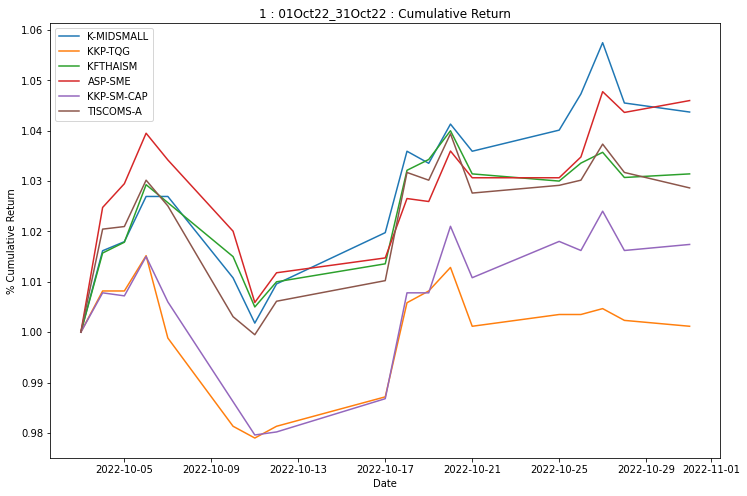

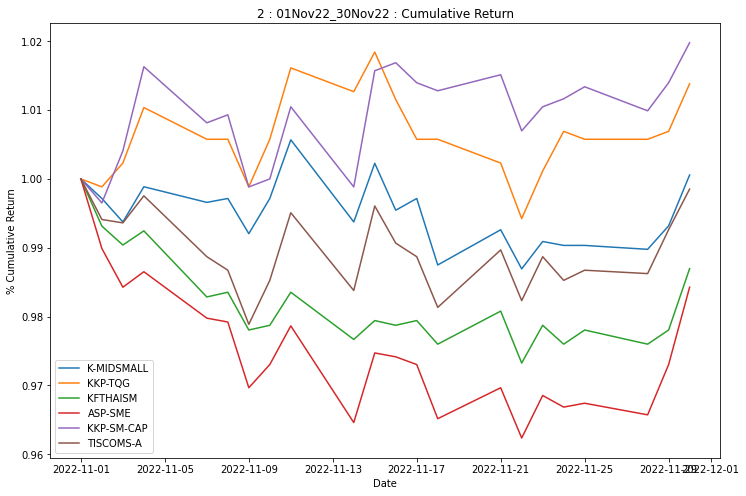

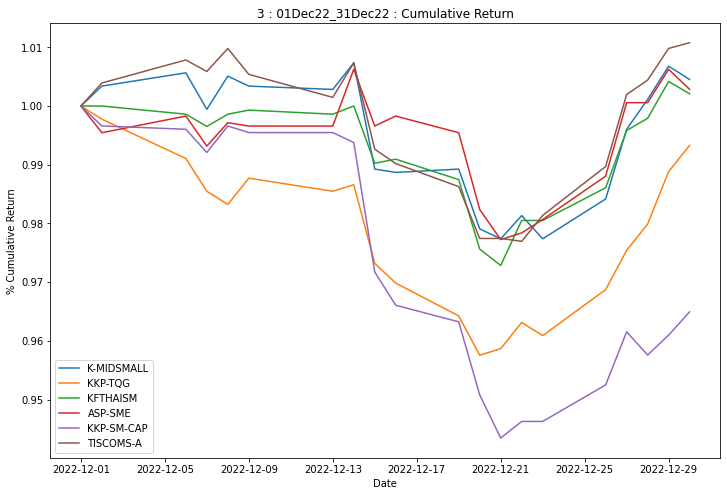

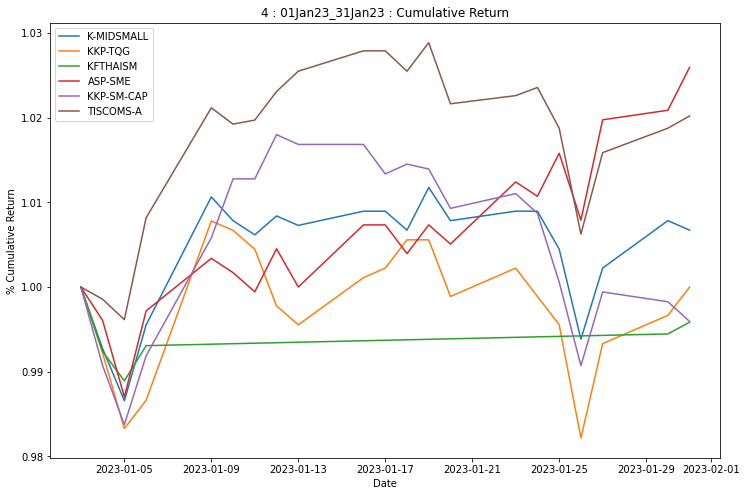

In [28]:
# plot chart line to compare return performace on each period
count_pic=0
for index,item in fundPerfByPeriod_df.iterrows():
    
    start_date=item['Start_Date']
    end_date=item['End_Date']
    
    
    fig = plt.figure(figsize = (12, 8))
    for fund_name,fund_df in dictPriceOfFund.items():
      df=create_pct_acc_df(fund_df,start_date,end_date)  
      #print(df.head())
      plt.plot(df.index,df['cum_return_pct'],label =fund_name)  

    plt.legend() 
    plt.xlabel("Date")
    plt.ylabel("% Cumulative Return")
    
    
    count_pic=count_pic+1
    plt.title(f"{count_pic} : {item['Period']} : Cumulative Return")
    # plt.savefig(f'{report_path}\\{count_pic}-{item["Period"]}.png')
    
    plt.show()

# Find Percent of Change (ROC) and  Statistic description

In [29]:
def cal_percent_return(item,fundTemp_df):
    
    start_date=item['Start_Date']
    end_date=item['End_Date']
    
    # filter by date to find ROC of price column during the period
    tempDF=fundTemp_df.loc[start_date:end_date,:]
    
    start_price=float(tempDF.iloc[0, 0])  # the first record of each period
    end_price=float(tempDF.iloc[len(tempDF)-1, 0]) # the last record of each period
    
    invest_return =(end_price-start_price)/start_price*100
    invest_return=round(invest_return,1)    
    
    print(f"{start_date.strftime('%d%b%y')} to {end_date.strftime('%d%b%y')}: ROC = { start_price} - {end_price}= {invest_return} %")
    
    return invest_return

print("Add column by each ROC of symbol")
for name,data in dictPriceOfFund.items():

  print(f"=========================={name} - cal_percent_return==================================================")
  fundPerfByPeriod_df[name]=fundPerfByPeriod_df.apply(cal_percent_return,axis=1,args=(data,))
  print("***********************************************************************************************")

fundPerfByPeriod_df


Add column by each ROC of symbol
==========================K-MIDSMALL - cal_percent_return==================================================
01Oct22 to 31Oct22: ROC = 16.7 - 17.43= 4.4 %
01Nov22 to 30Nov22: ROC = 17.6 - 17.61= 0.1 %
01Dec22 to 31Dec22: ROC = 17.68 - 17.76= 0.5 %
01Jan23 to 31Jan23: ROC = 17.86 - 17.98= 0.7 %
***********************************************************************************************
==========================KKP-TQG - cal_percent_return==================================================
01Oct22 to 31Oct22: ROC = 8.56 - 8.57= 0.1 %
01Nov22 to 30Nov22: ROC = 8.68 - 8.8= 1.4 %
01Dec22 to 31Dec22: ROC = 8.95 - 8.89= -0.7 %
01Jan23 to 31Jan23: ROC = 8.97 - 8.97= 0.0 %
***********************************************************************************************
==========================KFTHAISM - cal_percent_return==================================================
01Oct22 to 31Oct22: ROC = 14.0 - 14.44= 3.1 %
01Nov22 to 30Nov22: ROC = 14.58 - 14.39= -1.

,Start_Date,End_Date,Period,K-MIDSMALL,KKP-TQG,KFTHAISM,ASP-SME,KKP-SM-CAP,TISCOMS-A
0,2022-10-01,2022-10-31,01Oct22_31Oct22,4.4,0.1,3.1,4.6,1.7,2.9
1,2022-11-01,2022-11-30,01Nov22_30Nov22,0.1,1.4,-1.3,-1.6,2.0,-0.1
2,2022-12-01,2022-12-31,01Dec22_31Dec22,0.5,-0.7,0.2,0.3,-3.5,1.1
3,2023-01-01,2023-01-31,01Jan23_31Jan23,0.7,0.0,-0.4,2.6,-0.4,2.0


In [31]:
fundPerfByPeriod_df["_AVG_"]=fundPerfByPeriod_df[list_fund_name].mean(axis=1,skipna=True).round(1)
fundPerfByPeriod_df

,Start_Date,End_Date,Period,K-MIDSMALL,KKP-TQG,KFTHAISM,ASP-SME,KKP-SM-CAP,TISCOMS-A,_AVG_
0,2022-10-01,2022-10-31,01Oct22_31Oct22,4.4,0.1,3.1,4.6,1.7,2.9,2.8
1,2022-11-01,2022-11-30,01Nov22_30Nov22,0.1,1.4,-1.3,-1.6,2.0,-0.1,0.1
2,2022-12-01,2022-12-31,01Dec22_31Dec22,0.5,-0.7,0.2,0.3,-3.5,1.1,-0.4
3,2023-01-01,2023-01-31,01Jan23_31Jan23,0.7,0.0,-0.4,2.6,-0.4,2.0,0.8


In [ ]:
for

In [40]:
statDesc_df=fundPerfByPeriod_df[list_fund_name].describe()
statDesc_df =statDesc_df.T
statDesc_df=statDesc_df.loc[:,['mean','50%', 'std','max','min']]   
statDesc_df

,mean,50%,std,max,min
IWVL.L,1.433333,1.65,12.850068,17.3,-26.1
IWQU.L,2.125000,6.55,11.370066,19.7,-17.8
SPY,1.883333,5.60,12.668130,25.3,-20.7


# Plot Bar Perfoamce

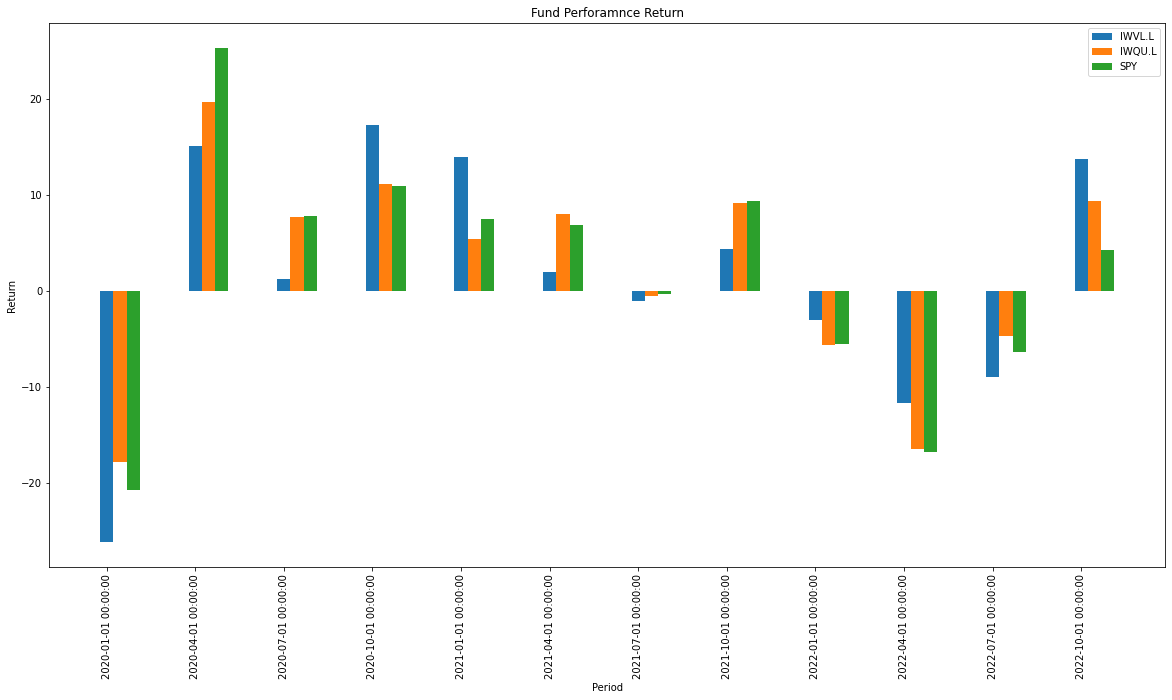

,IWVL.L,IWQU.L,SPY
Start_Date,,,
2020-01-01,-26.1,-17.8,-20.7
2020-04-01,15.1,19.7,25.3
2020-07-01,1.3,7.7,7.8
2020-10-01,17.3,11.1,10.9
2021-01-01,14.0,5.4,7.5
2021-04-01,2.0,8.0,6.9
2021-07-01,-1.0,-0.5,-0.3
2021-10-01,4.4,9.2,9.4
2022-01-01,-3.0,-5.6,-5.5


In [41]:
fundReturn_df=fundPerfByPeriod_df[["Start_Date"]+list_fund_name]
fundReturn_df.set_index("Start_Date",inplace=True)

fig = plt.figure(figsize = (20, 10))
X_axis = np.arange(len(fundReturn_df)) # length of column to fix axis=y
X_point=0.00
X_width=0.15

for colName  in fundReturn_df.columns:
    
    plt.bar(X_axis+X_point,fundReturn_df[colName],X_width, label =colName)
    X_point+=X_width

# length of column to fix axis=y
plt.xticks(X_axis, fundReturn_df.index,rotation='vertical')
plt.xlabel("Period")
plt.ylabel("Return")
plt.title(f"Fund Perforamnce Return")
plt.legend()

plt.savefig(f'{report_path}\\Return_{from_str}_{to_str}.png')

plt.show()

fundReturn_df

# Plot correlation

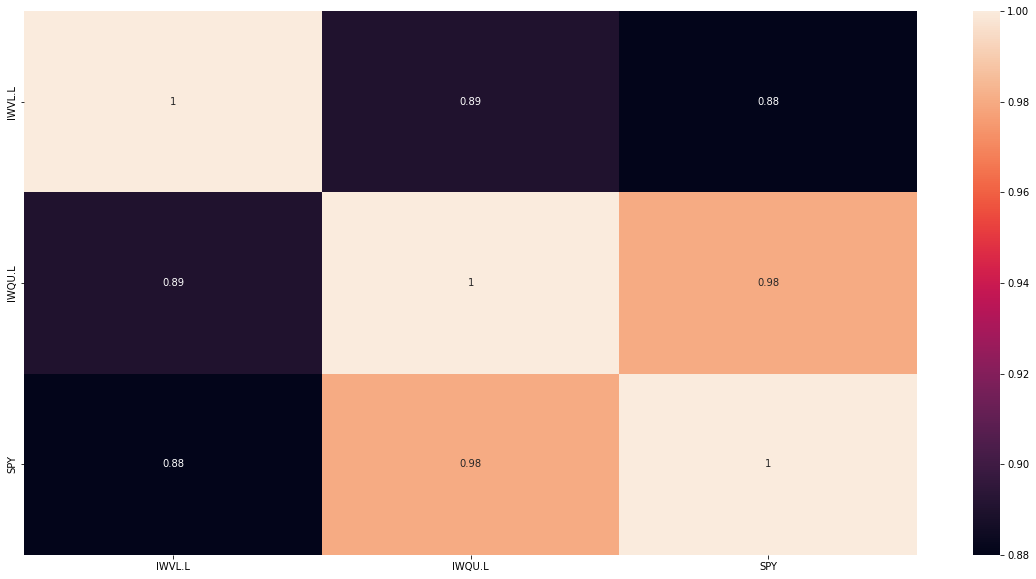

,IWVL.L,IWQU.L,SPY
IWVL.L,1.00,0.89,0.88
IWQU.L,0.89,1.00,0.98
SPY,0.88,0.98,1.00


In [42]:
corr_df = fundReturn_df.corr ()  
corr_df = corr_df .round(2)

fig = plt.figure(figsize = (20, 10))
heatmap = seaborn. heatmap(corr_df, annot = True)  

plt.savefig(f'{report_path}\\Corr_{from_str}_{to_str}.png')
plt. show ()  

corr_df

In [43]:
report_file = os.path .join(report_path, "Report.xlsx")
writer=pd.ExcelWriter(report_file,engine='xlsxwriter') 


fundPerfByPeriod_df.to_excel(writer, sheet_name="Return",index=False)
statDesc_df.to_excel(writer, sheet_name="Des",index=True)
corr_df.to_excel(writer, sheet_name="Des",index=True)
writer.save()

C:\Users\pongthsa\AppData\Local\Temp\ipykernel_18692\190226499.py:8: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer.save()
